# Relativistic Quantum Scattering Simulation (CUDA Wrapper)

This notebook provides a Python interface to the CUDA-accelerated FDTD solver for the Relativistic Schrödinger Equation. 
It solves the steady-state scattering problem $\nabla^2 \psi + k(r)^2 \psi = 0$ by simulating the time-evolution of a continuous wave source until it reaches equilibrium.

**Physics:**
The solver simulates a relativistic electron beam with energy $E = mc^2 + T$ scattering off a static potential $V(r)$.
The effective potential seen by the simulation is derived from the relativistic dispersion relation $p^2 c^2 = (E-V)^2 - m^2 c^4$.

**Usage:**
1. Define your potential map $V(x,y)$ in Python.
2. Run the simulation wrapper.
3. Visualize the resulting Scattered Wave Intensity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from fdtd_solver import RelativisticSolver, calculate_physics_params

%matplotlib widget 

# Initialize Solver (auto-compiles if needed)
solver = RelativisticSolver(source_file="fdtd_open_boundaries.cu")

## 1. Define Your Potential
Create a function that returns the potential $V(x,y)$.
The solver expects the *relativistic effective potential* logic to be handled internally. 
**Input here is the PHYSICAL potential V(r) (e.g. Coulomb, Square Well).**

Example: Two Atoms (Diatomic Molecule)

Goal: 0.025 A -> E_sim = 8844.0663 a.u.


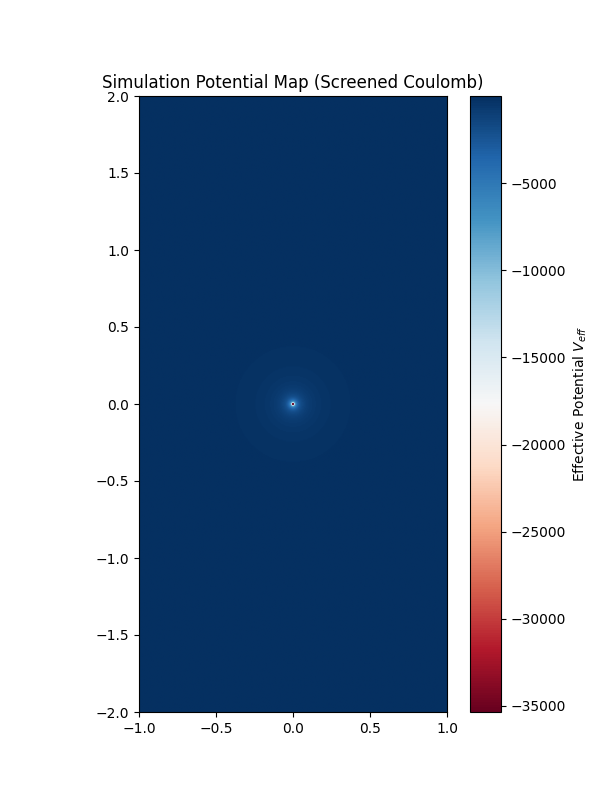

In [2]:
# --- 1. Simulation Constants ---
WAVELENGTH_ANGSTROM = 0.025
SOL_LIGHT = 137.036
MASS_PART = 1.0

# Calculate physics (for potential generation)
E_TOTAL_CALC, P_INF_CALC, E_SIM_CALC = calculate_physics_params(WAVELENGTH_ANGSTROM)
print(f"Goal: {WAVELENGTH_ANGSTROM} A -> E_sim = {E_SIM_CALC:.4f} a.u.")

# --- 2. Define Simulation Grid & Potential ---
NX, NY = 360, 640
XMIN, XMAX = -1.0, 1.0
YMIN, YMAX = -2.0, 2.0  # Propagating Top -> Bottom (High Y to Low Y)

def create_potential_map(nx, ny):
    x = np.linspace(XMIN, XMAX, nx)
    y = np.linspace(YMIN, YMAX, ny)
    X, Y = np.meshgrid(x, y)
    
    # --- USER DEFINED PHYSICAL POTENTIAL V(r) ---
    r = np.sqrt(X**2 + Y**2 + 0.0001**2)
    Z = 79.0 # Gold Atom
    
    # Use Screened Coulomb (Yukawa) for Neutral Atom
    # Screening length approx 0.5 a.u. (Thomas-Fermi)
    R_screen = 0.5
    V_phys = (-Z / r) * np.exp(-r / R_screen)
    # --------------------------------------------
    
    # Convert Physical Potential -> Relativistic Effective Potential V_eff
    # k^2(r) = [(E_tot - V)^2 - m^2 c^4] / c^2
    term1 = (E_TOTAL_CALC - V_phys)
    term2 = MASS_PART * SOL_LIGHT**2
    k2_local = (term1**2 - term2**2) / (SOL_LIGHT**2)
    
    # V_eff = E_sim - 0.5 * k^2
    V_eff = E_SIM_CALC - 0.5 * k2_local
    
    return V_eff.astype(np.float32)

V_sim = create_potential_map(NX, NY)

plt.figure(figsize=(6, 8))
plt.imshow(V_sim, extent=[XMIN, XMAX, YMIN, YMAX], cmap='RdBu', origin='lower')
plt.colorbar(label="Effective Potential $V_{eff}$")
plt.title("Simulation Potential Map (Screened Coulomb)")
plt.show()

## 2. Run Simulation
Write the potential to disk, call the CUDA solver, and load the result.

In [3]:
# --- 3. Run Simulation ---
# This wrapper handles:
# 1. Re-compiling C++ code if grid size/extent changes
# 2. Writing input files
# 3. Running the CUDA binary
# 4. Loading output snapshots

result = solver.run(
    V_sim, 
    wavelength_angstrom=WAVELENGTH_ANGSTROM,
    extent=(XMIN, XMAX, YMIN, YMAX),
    n_frames=800,
    steps_per_frame=400,
    snapshot_count=800
)

if result:
    snapshots = result['snapshots']
    dt_sim = result['dt']
    E_sim_file = result['E_sim']
    print(f"Simulation Successful. Loaded {len(snapshots)} frames.")
else:
    print("Simulation Failed.")

Compiling CUDA solver...
Compilation successful: fdtd_open_boundaries
Running: fdtd_open_boundaries 800 400 800 -0.025
Loaded 800 snapshots.
Simulation Successful. Loaded 800 frames.


In [4]:
# --- 4. Visualize Video ---
import matplotlib.animation as animation
from IPython.display import Video

fig, ax = plt.subplots(figsize=(6, 8))
t0, phi0, psi0 = snapshots[0]
intensity0 = phi0**2 + psi0**2
im = ax.imshow(intensity0, extent=[XMIN, XMAX, YMIN, YMAX], cmap='inferno', animated=True, origin='lower')
ax.set_title("Wavefront Intensity (t=0.00)")
ax.set_xlabel("x (a.u.)")
ax.set_ylabel("y (a.u.)")
# plt.colorbar(im, ax=ax, label='Intensity')

def update(frame_idx):
    # Skip frames to make video faster if needed
    t, phi, psi = snapshots[frame_idx]
    current_intensity = phi**2 + psi**2
    im.set_array(current_intensity)
    ax.set_title(f"Wavefront Intensity (t={t:.2f} a.u.)")
    return im,

ani = animation.FuncAnimation(fig, update, frames=len(snapshots), interval=30, blit=True)
ani.save("wavefront_intensity.mp4", writer='ffmpeg', fps=30, dpi=100)
plt.close(fig)

Video("wavefront_intensity.mp4")

Averaging over last 160 frames...


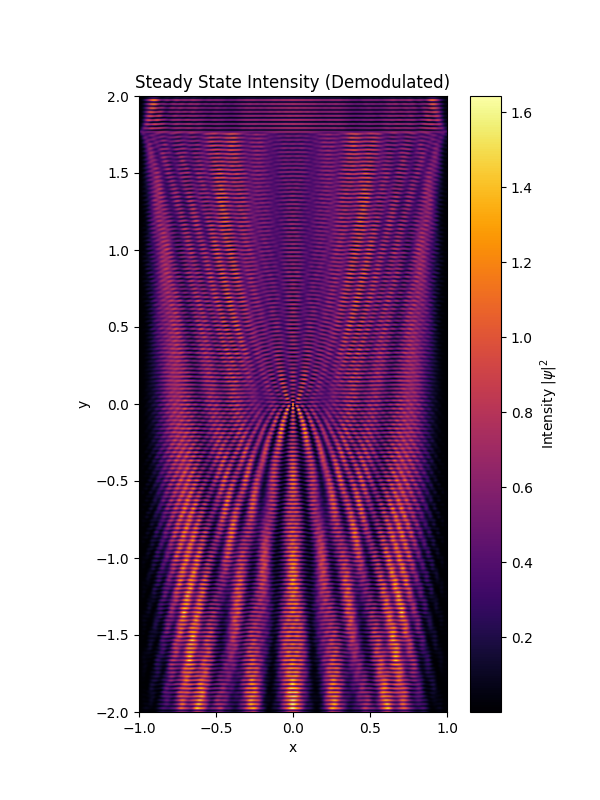

In [7]:
# --- 5. Extract Steady State (Demodulation) ---
# Average last 20% of frames to cancel out forward/backward time-dependent terms

start_avg = int(0.8 * len(snapshots))
subset = snapshots[start_avg:]
print(f"Averaging over last {len(subset)} frames...")

A_steady = np.zeros_like(snapshots[0][1], dtype=np.complex128)

for t_val, phi_val, psi_val in subset:
    psi_c = phi_val + 1j * psi_val
    # Demodulate: multiply by exp(+i E t)
    phasor = np.exp(1j * E_sim_file * t_val)
    A_steady += psi_c * phasor

A_steady /= len(subset)
intensity_steady = np.abs(A_steady)**2

plt.figure(figsize=(6, 8))
plt.imshow(intensity_steady, extent=[XMIN, XMAX, YMIN, YMAX], cmap='inferno', origin='lower')
plt.colorbar(label='Intensity $|\\psi|^2$')
plt.title("Steady State Intensity (Demodulated)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

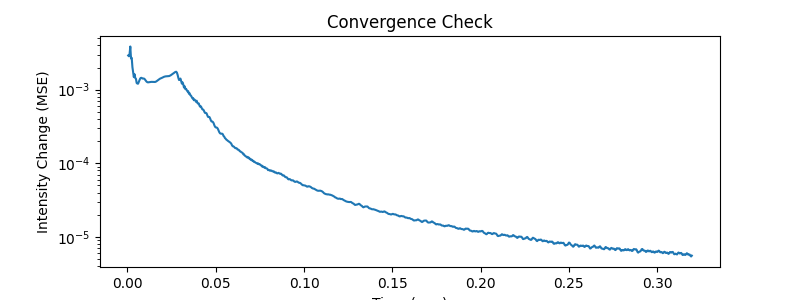

In [8]:
# --- 6. Convergence Check ---
# Ensure the solution has stopped evolving (MSE -> 0)
errors = []
times = []

for i in range(len(snapshots)-1):
    t1, phi1, psi1 = snapshots[i]
    t2, phi2, psi2 = snapshots[i+1]
    
    I1 = phi1**2 + psi1**2
    I2 = phi2**2 + psi2**2
    
    mse = np.mean((I2 - I1)**2)
    errors.append(mse)
    times.append(t2)

plt.figure(figsize=(8, 3))
plt.plot(times, errors)
plt.yscale('log')
plt.xlabel("Time (a.u.)")
plt.ylabel("Intensity Change (MSE)")
plt.title("Convergence Check")
plt.show()